# 使用档案模式的聊天机器人

## 回顾

我们介绍了 [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) 作为保存和检索长期记忆的方式。

我们构建了一个简单的聊天机器人，使用`短期（线程内）`和`长期（跨线程）`记忆。

它保存长期[语义记忆](https://docs.langchain.com/oss/python/concepts/memory#semantic-memory)（关于用户的事实）["在热路径中"](https://docs.langchain.com/oss/python/concepts/memory#writing-memories)，即在用户与其聊天时。

## 目标

我们的聊天机器人将记忆保存为字符串。在实践中，我们通常希望记忆具有结构。

例如，记忆可以是[单个、持续更新的模式](https://docs.langchain.com/oss/python/concepts/memory#profile)。

在我们的情况下，我们希望这是一个单一的用户档案。

我们将扩展聊天机器人，将语义记忆保存到单个[用户档案](https://docs.langchain.com/oss/python/concepts/memory#profile)中。

我们还将介绍一个库，[Trustcall](https://github.com/hinthornw/trustcall)，用于使用新信息更新此模式。

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 定义用户档案模式

Python 有许多不同类型的[结构化数据](https://docs.langchain.com/oss/python/langchain/models#structured-outputs)，如 TypedDict、字典、JSON 和 [Pydantic](https://docs.pydantic.dev/latest/)。

让我们从使用 TypedDict 定义用户档案模式开始。

In [3]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## 将模式保存到存储

[LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) 接受任何 Python 字典作为 `value`。

In [4]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

我们使用 [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) 方法将 TypedDict 保存到存储中。

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

我们使用 [search](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.search) 通过命名空间从存储中检索对象。

In [6]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'key': 'user_profile', 'namespace': ['1', 'memory'], 'created_at': '2024-11-04T23:37:34.871675+00:00', 'updated_at': '2024-11-04T23:37:34.871680+00:00'}


我们还可以使用 [get](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.get) 通过命名空间和键检索特定对象。

In [7]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## 使用档案模式的聊天机器人

现在我们知道如何为记忆指定模式并将其保存到存储中。

现在，我们如何实际*创建*具有这种特定模式的记忆呢？

在我们的聊天机器人中，我们[希望从用户聊天中创建记忆](https://docs.langchain.com/oss/python/concepts/memory#profile)。

这就是[结构化输出](https://docs.langchain.com/oss/python/langchain/models#structured-outputs)概念的用武之地。

LangChain 的[聊天模型](https://docs.langchain.com/oss/python/langchain/models)接口有一个 [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) 方法来强制结构化输出。

当我们想要强制输出符合模式并为我们解析输出时，这很有用。

In [7]:
_set_env("OPENAI_API_KEY")

让我们将我们创建的 `UserProfile` 模式传递给 `with_structured_output` 方法。

然后我们可以使用[消息](https://docs.langchain.com/oss/python/langchain/messages)列表调用聊天模型，并获得符合我们模式的结构化输出。

In [8]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

现在，让我们在聊天机器人中使用它。

这只需要对 `write_memory` 函数进行少量更改。

我们使用如上定义的 `model_with_structure` 来生成符合我们模式的档案。

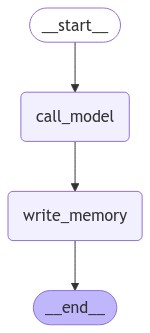

In [9]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! It's great to meet you. Biking around San Francisco sounds like a fantastic way to explore the city, and there are so many amazing bakeries to try. Do you have any favorite bakeries or biking routes in the city?


让我们检查存储中的记忆。

我们可以看到记忆是一个与我们模式匹配的字典。

In [11]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

## 这在什么时候会失败？

[`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) 非常有用，但如果我们处理更复杂的模式会发生什么？

[这里](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)是一个更复杂模式的例子，我们将在下面进行测试。

这是一个 [Pydantic](https://docs.pydantic.dev/latest/) 模型，描述了用户对通信和信任跌落的偏好。

In [18]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

现在，让我们尝试使用 `with_structured_output` 方法提取此模式。

In [19]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

1 validation error for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.semaphore
  Input should be a valid dictionary or instance of Semaphore [type=model_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type


如果我们天真地提取更复杂的模式，即使使用像 `gpt-4o` 这样的高容量模型，也容易失败。

## 用于创建和更新档案模式的 Trustcall

正如我们所看到的，使用模式可能很棘手。

复杂的模式可能很难提取。

此外，即使是简单的模式的更新也可能带来挑战。

考虑我们上面的聊天机器人。

每次我们选择保存新记忆时，我们都*从头开始*重新生成档案模式。

这是低效的，如果模式包含大量信息需要每次重新生成，可能会浪费模型令牌。

更糟糕的是，从头开始重新生成档案时我们可能会丢失信息。

解决这些问题是 [TrustCall](https://github.com/hinthornw/trustcall) 的动机！

这是一个用于更新 JSON 模式的开源库，由 LangChain 团队的 [Will Fu-Hinthorn](https://github.com/hinthornw) 开发。

它的动机正是在处理记忆时面临的这些挑战。

让我们首先展示在这个[消息](https://docs.langchain.com/oss/python/langchain/messages)列表上使用 TrustCall 进行简单提取的用法。

In [20]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

我们使用 `create_extractor`，传入模型以及我们的模式作为[工具](https://docs.langchain.com/oss/python/langchain/tools)。

使用 TrustCall，可以以各种方式提供模式。

例如，我们可以传递 JSON 对象 / Python 字典或 Pydantic 模型。

在底层，TrustCall 使用[工具调用](https://docs.langchain.com/oss/python/langchain/models#tool-calling)从输入的[消息](https://docs.langchain.com/oss/python/langchain/messages)列表生成[结构化输出](https://docs.langchain.com/oss/python/langchain/models#structured-outputs)。

要强制 Trustcall 生成结构化输出，我们可以在 `tool_choice` 参数中包含模式名称。

我们可以使用上述对话调用提取器。

In [21]:
from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

当我们调用提取器时，我们会得到一些东西：

* `messages`：包含工具调用的 `AIMessages` 列表。
* `responses`：与我们模式匹配的已解析工具调用结果。
* `response_metadata`：如果更新现有工具调用则适用。它说明哪些响应对应于哪些现有对象。

In [17]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_spGGUsoaUFXU7oOrUNCASzfL)
 Call ID: call_spGGUsoaUFXU7oOrUNCASzfL
  Args:
    user_name: Lance
    interests: ['biking around San Francisco']


In [18]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking around San Francisco'])]

In [19]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

In [20]:
result["response_metadata"]

[{'id': 'call_spGGUsoaUFXU7oOrUNCASzfL'}]

让我们看看如何使用它来*更新*档案。

对于更新，TrustCall 接收一组消息以及现有模式。

核心思想是它提示模型生成一个 [JSON Patch](https://jsonpatch.com/) 来仅更新模式的相关部分。

这比天真地覆盖整个模式更不容易出错。

它也更高效，因为模型只需要生成已更改的模式部分。

我们可以将现有模式保存为字典。

我们可以使用 `model_dump()` 将 Pydantic 模型实例序列化为字典。

我们将它与模式名称 `UserProfile` 一起传递给 `"existing"` 参数。

In [21]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [22]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_WeZl0ACfQStxblim0ps8LNKT)
 Call ID: call_WeZl0ACfQStxblim0ps8LNKT
  Args:
    user_name: Lance
    interests: ['biking', 'visiting bakeries']


In [23]:
result["response_metadata"]

[{'id': 'call_WeZl0ACfQStxblim0ps8LNKT'}]

In [24]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'visiting bakeries']}

LangSmith 追踪：

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

现在，让我们还在我们之前看到的[挑战性模式](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)上测试 Trustcall。

In [25]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='standard encoding', sentence_preference_revealed='standard encoding')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='higher')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='diamond formation')])))

追踪：

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

有关更多示例，你可以在[这里](https://www.youtube.com/watch?v=-H4s0jQi-QY)查看概述视频。

## 使用档案模式更新的聊天机器人

现在，让我们将 Trustcall 引入我们的聊天机器人，以创建*和更新*记忆档案。

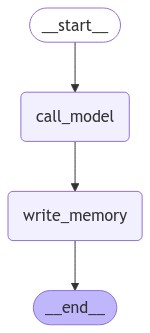

In [22]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [24]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful routes and views. Do you have any favorite trails or spots you like to visit while biking?


In [25]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-04T23:51:17.662428+00:00',
 'updated_at': '2024-11-04T23:51:41.697652+00:00'}

In [26]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [27]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and visiting bakeries sounds like a delightful combination! San Francisco has some fantastic bakeries. Do you have any favorites, or are you looking for new recommendations to try out?


在新线程中继续对话。

In [28]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you're in San Francisco and enjoy going to bakeries, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit for any bakery enthusiast.
2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.
3. **Arsicault Bakery** - Renowned for its croissants, which have been praised as some of the best in the country.
4. **Craftsman and Wolves** - Known for their inventive pastries and the "Rebel Within," a savory muffin with a soft-cooked egg inside.
5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

These spots should offer a great variety of treats for you to enjoy. Happy bakery hopping!


追踪：

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)